In [1]:
import os
import numpy as np
import time
from scipy.special import erfinv
from numpy import log, pi,sqrt, exp,cos,sin,tan,argpartition,copy,trapz,mean,cov,vstack,hstack
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import random
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def inv_trans(uniform, func, sigma=None, maxdv=None, dvcatas=1000, dvcatasmax=10**5.65): 
    # inverse function sampling
    if func == 'G':
        scathalf = int(len(uniform)/2)
        invfunc = np.append(sigma*sqrt(-2*log(uniform[:scathalf]))*cos(2*pi*uniform[-scathalf:]),sigma*sqrt(-2*log(uniform[:scathalf]))*sin(2*pi*uniform[-scathalf:]))
    elif func == 'L':
        invfunc = tan((2*uniform-1)*pi)*sigma/2
        # import pdb; pdb.set_trace()
        outliers= abs(invfunc)>maxdv
        while len(outliers)>0:
            uni_tmp = np.random.RandomState(seed=int(time.time())).rand(np.sum(outliers))
            invfunc[outliers] = tan((2*uni_tmp-1)*pi)*sigma/2   
            outliers= abs(invfunc)>maxdv
    elif func == 'lnG':
        invfunc = 6.499-exp((253*erfinv(1-2000/991*uniform)+37*2**3.5)/125/2**2.5)    
        outliers= (invfunc<np.log10(dvcatas))|(invfunc>np.log10(dvcatasmax))|(~np.isfinite(invfunc))
        while np.sum(outliers)>0:
            uni_tmp = np.random.RandomState(seed=int(time.time())).rand(np.sum(outliers))
            invfunc[outliers] = 6.499-exp((253*erfinv(1-2000/991*uni_tmp)+37*2**3.5)/125/2**2.5)   
            outliers= (invfunc<np.log10(dvcatas))|(invfunc>np.log10(dvcatasmax))|(~np.isfinite(invfunc))
    return invfunc

In [3]:
def dv_vsmear(uniform, target, redshift, smeartype='G'):
    # redshift uncertainty with vsmear model
    if target == 'LRG':
        Lmaxdv  = 400 # if 'L', 400 for LRGs and 2000 for QSOss
        if redshift == 0.5:
            sigma = 37.2
        elif redshift == 1.0:
            sigma = 85.7
        else:
            sigma = 0.0
    elif target == 'QSO':
        Lmaxdv  = 2000 # if 'L', 400 for LRGs and 2000 for QSOss
        if redshift == 1.0:
            sigma = 200.0
        else:
            sigma = 0.0
    if smeartype == 'G':
        vsmear = inv_trans(uniform, func='G', sigma=sigma, maxdv=None)
    elif smeartype == 'L':
        vsmear = inv_trans(uniform, func='L', sigma=sigma, maxdv=Lmaxdv)
    # Z_position = (Z_position+vcatas*(1+redshift)/H)%boxsize
    return vsmear

def dv_catas(uniform, rate, redshift):

    # implement the catastrophic failure
    if rate == '1%CATAS':
        catas_rate = 1/100
    elif rate == '5%CATAS':
        catas_rate = 5/100
    else:
        catas_rate = 0 
    Nfail       = int(len(uniform)*catas_rate) if int(len(uniform)*catas_rate)%2==0 else int(len(uniform)*catas_rate)+1
    inds        = random.sample(range(0, len(uniform)), Nfail)
    dv_uniform  = np.random.rand(Nfail)        
    half        = int(len(dv_uniform)/2)
    dv_pos      = inv_trans(dv_uniform[:half], func='lnG')
    dv_neg      = inv_trans(dv_uniform[half:], func='lnG')
    dv          = np.append(10**dv_pos,-10**dv_neg)
    random.shuffle(dv)
    # vcatas    = np.zeros_like(uniform)
    # vcatas[inds] = dv.copy()
    return dv

[0.43499858 0.36696991 0.64543125 ... 0.96948007 0.9037447  0.73993793]


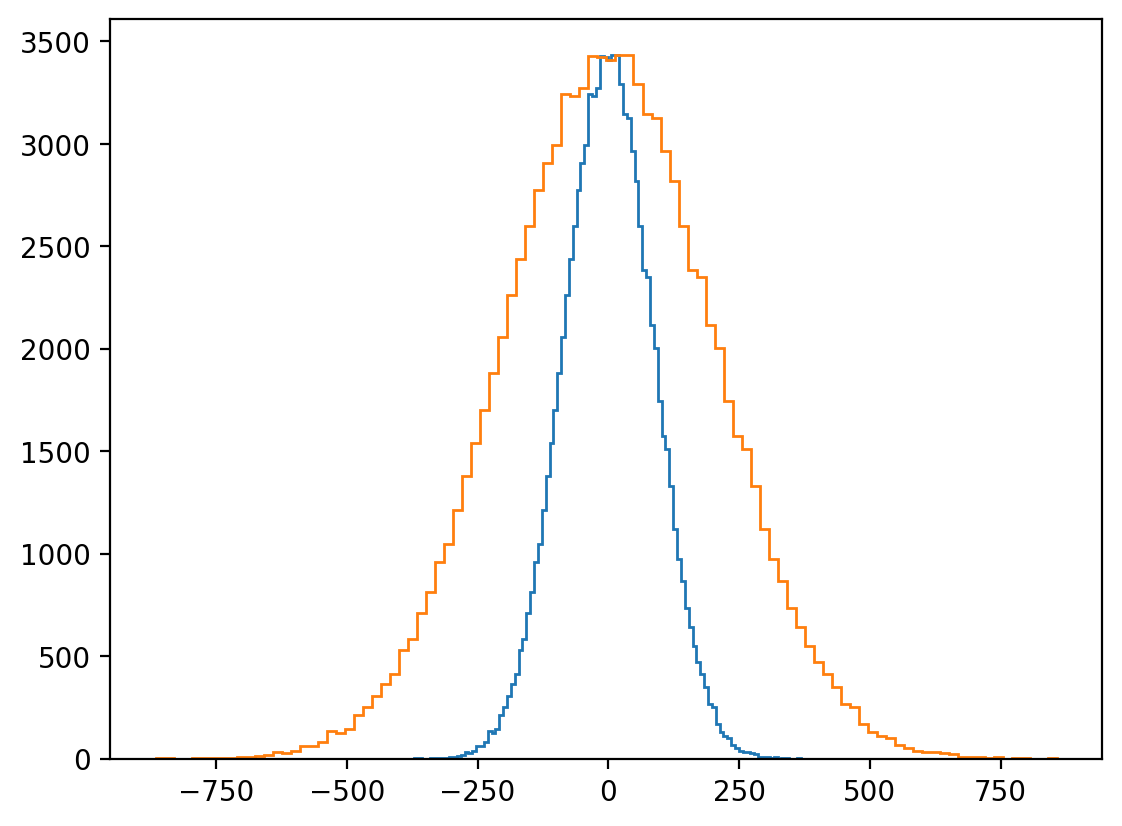

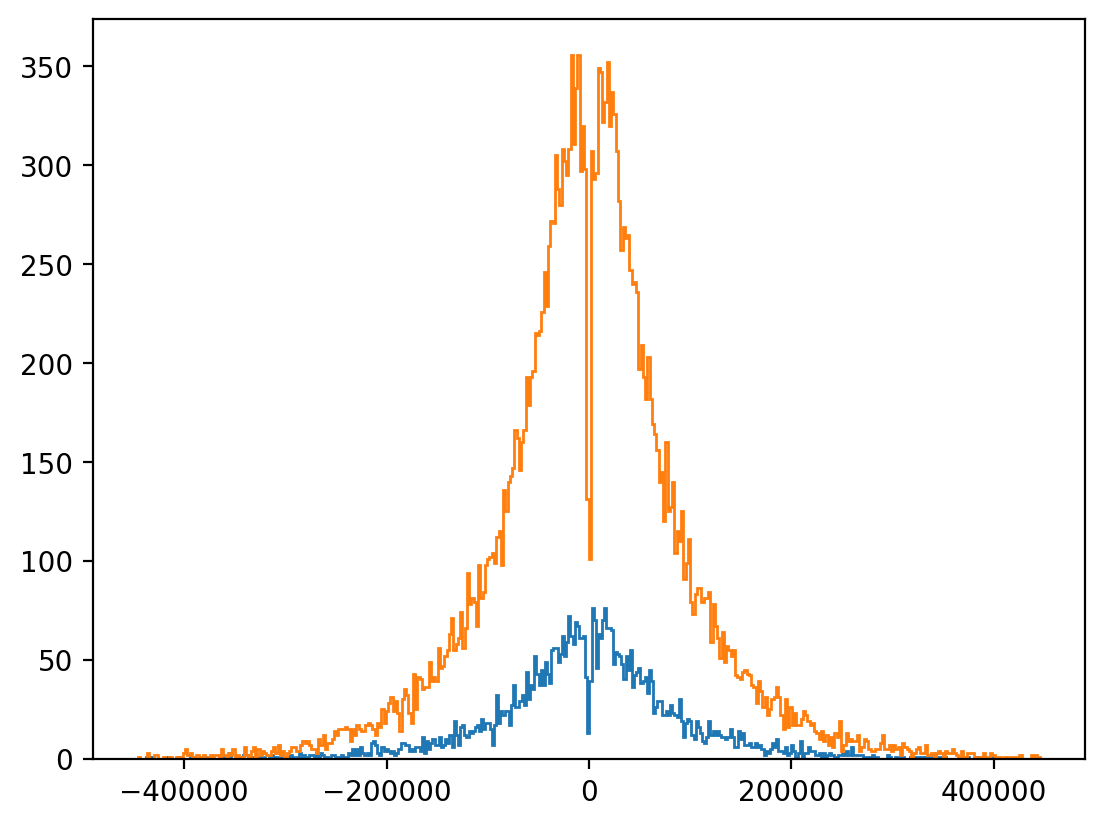

In [4]:
import time
bins=np.linspace(0, 10, 20)
uniform    = np.random.RandomState(seed=int(time.time())).rand(100000)
print(uniform)
vsmear_LRG = dv_vsmear(uniform, 'LRG', redshift = 1.0)
vsmear_QSO = dv_vsmear(uniform, 'QSO', redshift = 1.0)
# plt.hist(vsmear_QSO, color='C1', lw=0, bins=100)
plt.stairs(*np.histogram(vsmear_LRG, bins=100))
plt.stairs(*np.histogram(vsmear_QSO, bins=100))
plt.show()

uniform    = np.random.RandomState(seed=int(time.time())).rand(500000)
vsmear_1catas = dv_catas(uniform, '1%CATAS', redshift = 1.0)
vsmear_5catas = dv_catas(uniform, '5%CATAS', redshift = 1.0)

plt.stairs(*np.histogram(vsmear_1catas, bins=400))
plt.stairs(*np.histogram(vsmear_5catas, bins=400))
plt.show()


In [5]:
def dataload(data):
    Pk0 = [[],[]]
    Pk2 = [[],[]]
    k = data[0,:,1]
    l0 = data[:,:,3]
    l2 = data[:,:,4]
    Pk0[0] = np.mean(l0,axis=0)
    Pk0[1] = np.std(l0,axis=0)
    Pk2[0] = np.mean(l2,axis=0)
    Pk2[1] = np.std(l2,axis=0)
    pk_cov = np.append(l0,l2,axis=1)
    cov = np.cov(np.array(pk_cov).T)
    # icov = np.linalg.inv(cov)
    return (k,Pk0,Pk2, cov)

/Users/alain/Desktop/projectNU/main/data/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/1%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/5%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk


/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_9203/2212140013.py:47: RuntimeWarning: invalid value encountered in divide
  axs[i][k].plot(k_ev, (Pkobs[t][i][0]/Pkobs[0][i][0]), color = colors[i], linestyle=lss[z])


/Users/alain/Desktop/projectNU/main/data/fiducial/1%CATAS_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/5%CATAS_z1.0/pk/fiducial_199_z1.0.pk


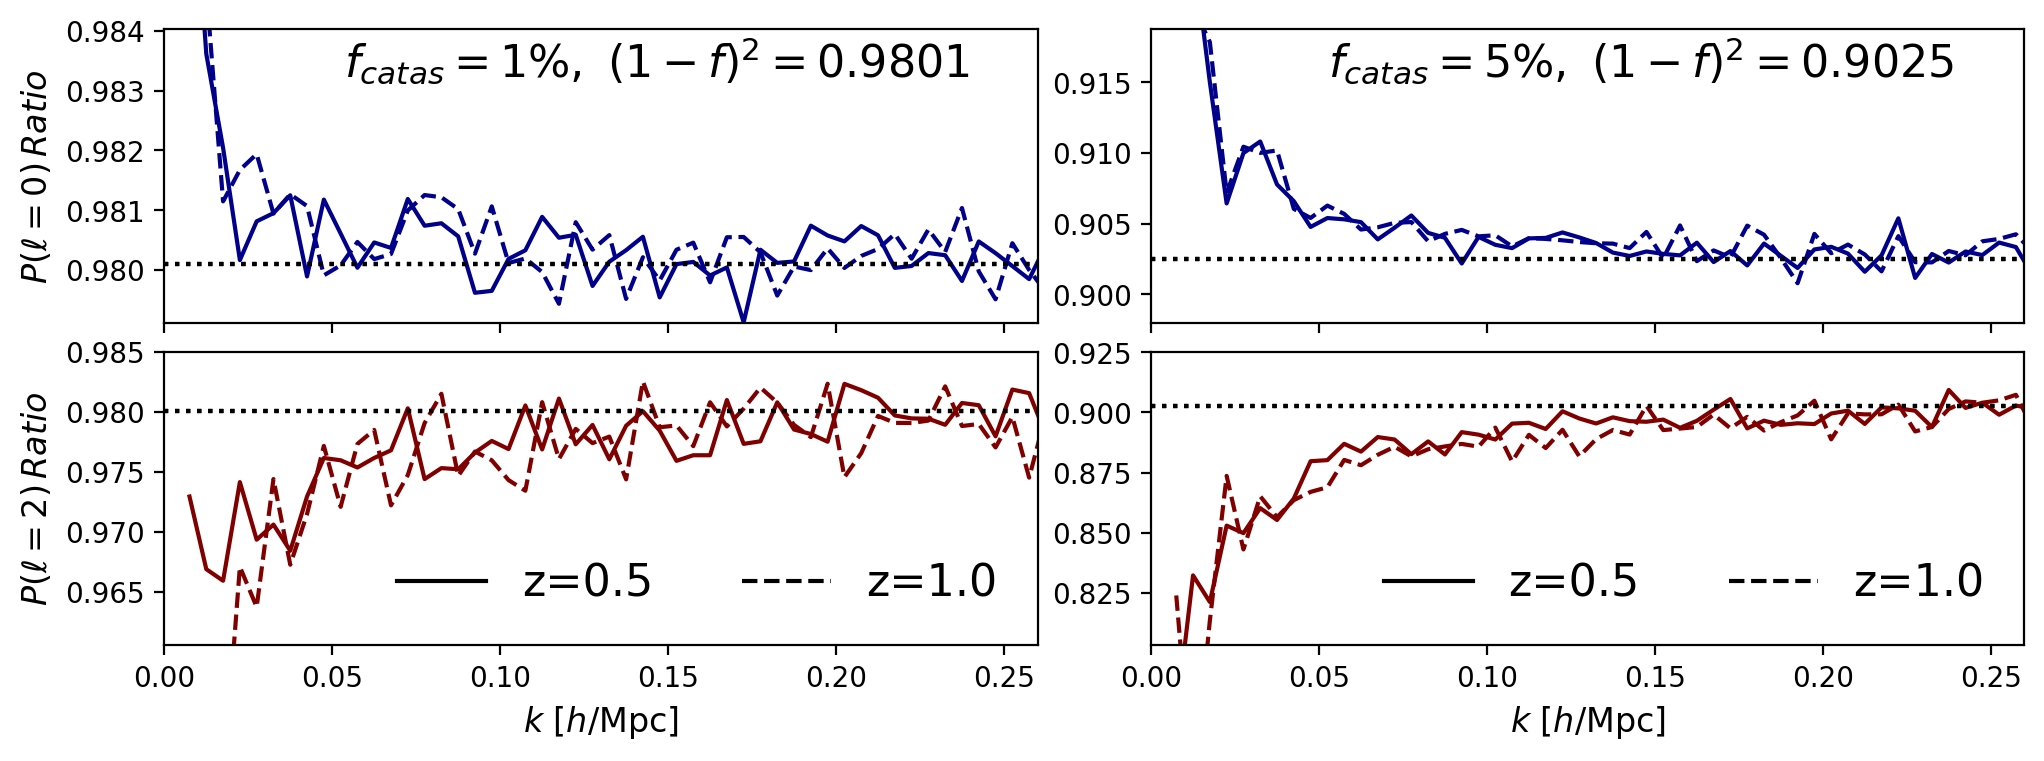

In [6]:
def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/{catalogue}/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

label_fontsize = 12
legend_fontsize = 16
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRG vsmear',
    'QSO': '+QSO vsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize = (12, 4))
fig.subplots_adjust(wspace=0.13)
fig.subplots_adjust(hspace=0.1)

colors = ['darkblue', 'maroon']
lss = ['-', '--']

for z, redshift in enumerate([0.5, 1.0]):
    Pkobs   = []
    labels  = []
    for t,r_pk in enumerate(['RSD','1%CATAS','5%CATAS']):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0, pk2])
        labels.append(f'obs {systematic}')
        if t == 0:
            rsf = 5
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]
    for t in [1,2]:
        k = t-1
        for ell, i in zip(['monopole','quadrupole'],range(2)):
            axs[i][k].plot(k_ev, (Pkobs[t][i][0]/Pkobs[0][i][0]), color = colors[i], linestyle=lss[z])
            # axs[i][k].fill_between(k_ev,  (Pkobs[t][i][0]-Pkobs[t][i][1])/Pkobs[0][i][0],
            #                     (Pkobs[t][i][0]+Pkobs[t][i][1])/Pkobs[0][i][0],alpha=0.6, color='grey')  
            axs[1][k].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
            axs[i][0].set_ylabel(r'$P(\ell = {}) \, Ratio$'.format(i*2), fontsize = label_fontsize)
            axs[i][0].axhline((1-0.01)**2, color='k', linestyle=':', alpha=0.8)
            axs[i][1].axhline((1-0.05)**2, color='k', linestyle=':', alpha=0.8)
            axs[i][k].set_xlim([0.0,0.26])

axs[0][0].set_ylim([(1-0.01)**2*0.999, (1-0.01)**2*1.004,])
axs[1][0].set_ylim([(1-0.01)**2*0.98, (1-0.01)**2*1.005,])
axs[0][1].set_ylim([(1-0.05)**2*0.995, (1-0.05)**2*1.018])
axs[1][1].set_ylim([(1-0.05)**2*0.89, (1-0.05)**2*1.025,])

line1= Line2D([0], [0], label='z=0.5', color='black', linestyle= '-')
line2 = Line2D([0], [0], label='z=1.0', color='black', linestyle= '--')
leg1 = axs[1][0].legend(handles=[line1,line2], loc=4, ncols=2, fontsize=legend_fontsize)
leg1.get_frame().set_linewidth(0.0)
leg1 = axs[1][1].legend(handles=[line1,line2], loc=4, ncols=2, fontsize=legend_fontsize)
leg1.get_frame().set_linewidth(0.0)

plt.figtext(0.20, 0.82, r'$f_{catas}=1\%, \ (1-f)^2 = 0.9801$', fontsize=legend_fontsize)
plt.figtext(0.61, 0.82, r'$f_{catas}=5\%, \ (1-f)^2 = 0.9025$', fontsize=legend_fontsize)
plt.show()

/Users/alain/Desktop/projectNU/main/data/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/1%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/5%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/1%CATAS_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/5%CATAS_z1.0/pk/fiducial_199_z1.0.pk


/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_9203/1944019867.py:48: RuntimeWarning: invalid value encountered in divide
  axs[i][k].plot(k_ev, (Pkobs[t][i][0]/Pkobs[0][i][0]), color = colors[i], linestyle=lss[z])
/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_9203/1944019867.py:49: RuntimeWarning: invalid value encountered in divide
  axs[i][k].fill_between(k_ev,  (Pkobs[t][i][0]-error/rsf)/Pkobs[0][i][0],
/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_9203/1944019867.py:50: RuntimeWarning: invalid value encountered in divide
  (Pkobs[t][i][0]+error/rsf)/Pkobs[0][i][0], alpha=0.6, color='grey')


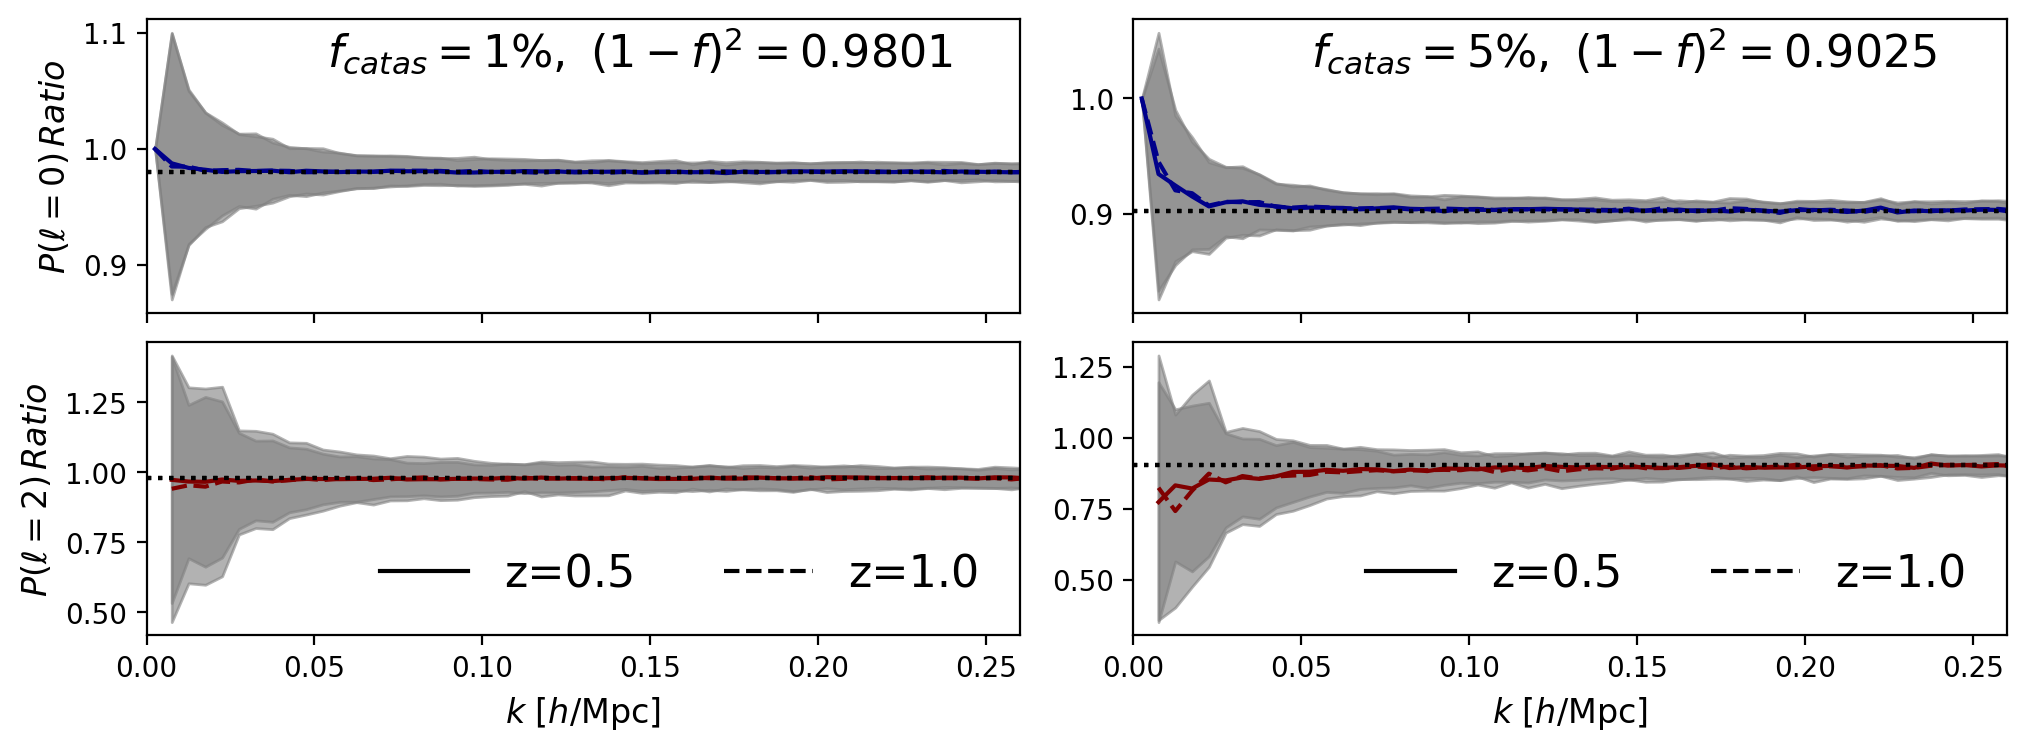

In [7]:
def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/{catalogue}/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

label_fontsize = 12
legend_fontsize = 16
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRG vsmear',
    'QSO': '+QSO vsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize = (12, 4))
fig.subplots_adjust(wspace=0.13)
fig.subplots_adjust(hspace=0.1)

colors = ['darkblue', 'maroon']
lss = ['-', '--']

for z, redshift in enumerate([0.5, 1.0]):
    Pkobs   = []
    labels  = []
    for t,r_pk in enumerate(['RSD','1%CATAS','5%CATAS']):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0, pk2])
        labels.append(f'obs {systematic}')
        if t == 0:
            rsf = 5
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]
    for t in [1,2]:
        k = t-1
        for ell, i in zip(['monopole','quadrupole'],range(2)):
            error = np.sqrt(Pkobs[t][i][1]**2+Pkobs[0][i][1]**2)
            axs[i][k].plot(k_ev, (Pkobs[t][i][0]/Pkobs[0][i][0]), color = colors[i], linestyle=lss[z])           
            axs[i][k].fill_between(k_ev,  (Pkobs[t][i][0]-error/rsf)/Pkobs[0][i][0],
                                (Pkobs[t][i][0]+error/rsf)/Pkobs[0][i][0], alpha=0.6, color='grey')              
            axs[1][k].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
            axs[i][0].set_ylabel(r'$P(\ell = {}) \, Ratio$'.format(i*2), fontsize = label_fontsize)
            axs[i][0].axhline((1-0.01)**2, color='k', linestyle=':', alpha=0.8)
            axs[i][1].axhline((1-0.05)**2, color='k', linestyle=':', alpha=0.8)
            axs[i][k].set_xlim([0.0,0.26])

line1= Line2D([0], [0], label='z=0.5', color='black', linestyle= '-')
line2 = Line2D([0], [0], label='z=1.0', color='black', linestyle= '--')
leg1 = axs[1][0].legend(handles=[line1,line2], loc=4, ncols=2, fontsize=legend_fontsize)
leg1.get_frame().set_linewidth(0.0)
leg1 = axs[1][1].legend(handles=[line1,line2], loc=4, ncols=2, fontsize=legend_fontsize)
leg1.get_frame().set_linewidth(0.0)

plt.figtext(0.20, 0.82, r'$f_{catas}=1\%, \ (1-f)^2 = 0.9801$', fontsize=legend_fontsize)
plt.figtext(0.61, 0.82, r'$f_{catas}=5\%, \ (1-f)^2 = 0.9025$', fontsize=legend_fontsize)
plt.show()

/Users/alain/Desktop/projectNU/main/data/catas/1%CATAS_z0.5/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/catas/5%CATAS_z0.5/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/catas/1%CATAS_z1.0/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/catas/5%CATAS_z1.0/fiducial_199_z1.0.pk


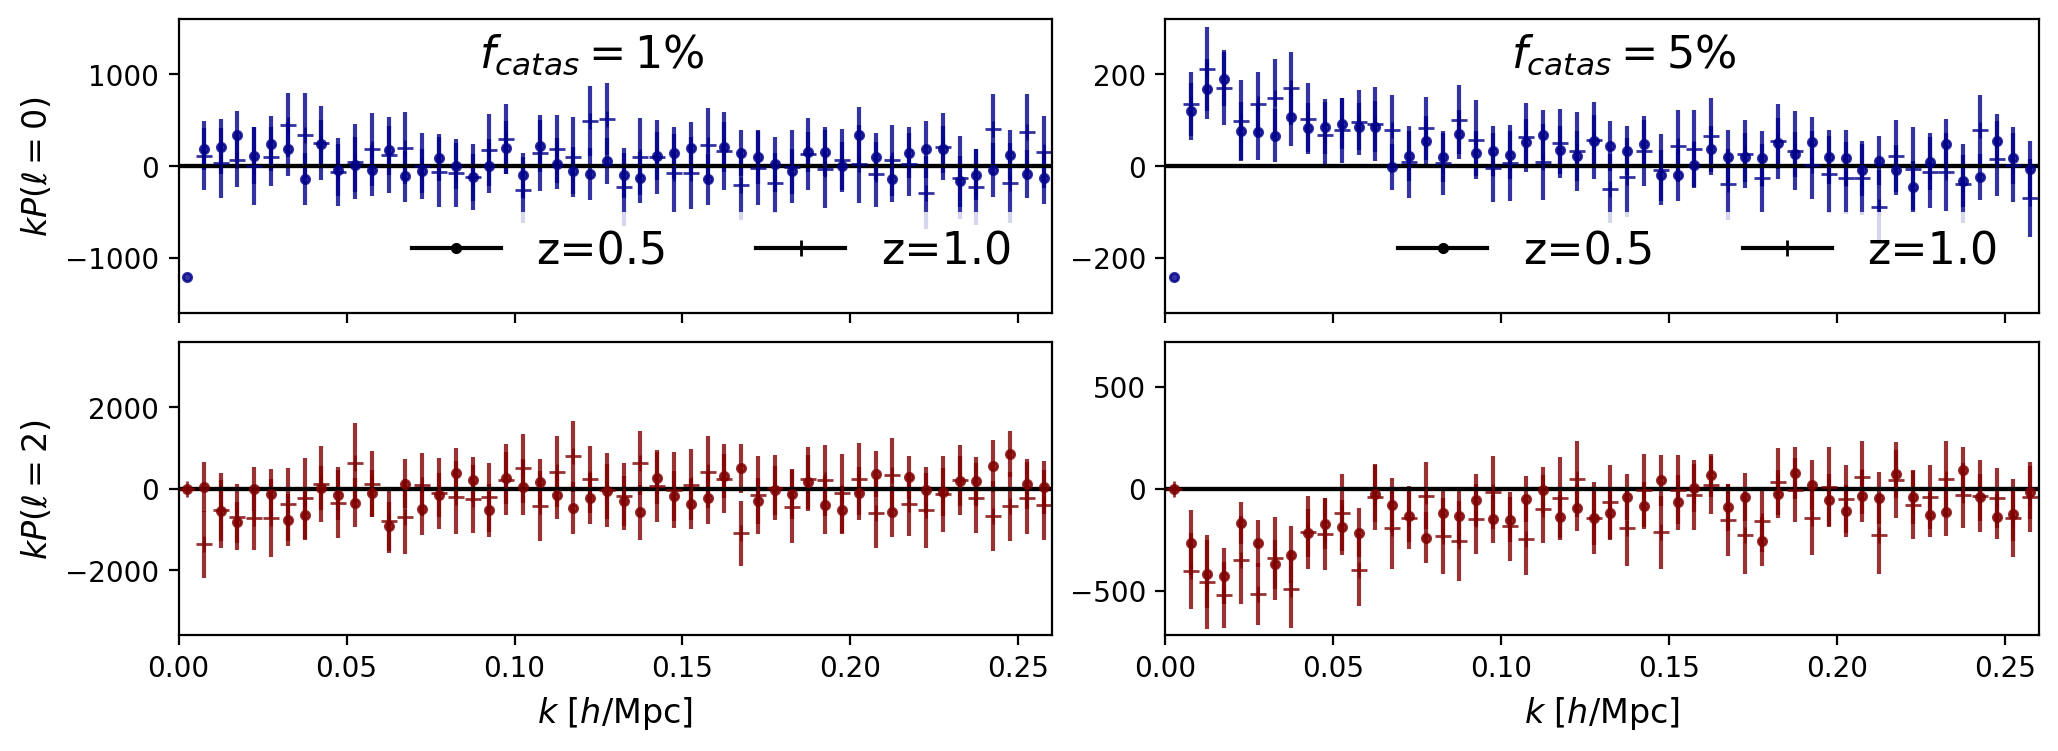

In [8]:
def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/catas/{r_pk}_z{redshift}'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_{r_pk}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

label_fontsize = 12
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRG vsmear',
    'QSO': '+QSO vsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize = (12, 4))
fig.subplots_adjust(wspace=0.13)
fig.subplots_adjust(hspace=0.1)

colors = ['darkblue', 'maroon']
fmts = ['.','+']

for z, redshift in enumerate([0.5, 1.0]):
    Pkobs   = []
    labels  = []
    for t,r_pk in enumerate(['1%CATAS','5%CATAS']):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0, pk2])
        labels.append(f'obs {systematic}')
        if t == 0:
            rsf = 5
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]

    for ell, i in zip(['monopole','quadrupole'],range(2)):
        for t in range(2):
            axs[i][t].errorbar(k_ev, k_ev*(Pkobs[t][i][0]), k_ev*Pkobs[t][i][1]/rsf,
                            color = colors[i], label = labels[t], fmt=fmts[z], alpha = 0.8)
            axs[i][t].axhline(0, color='k', linestyle='-', alpha=1.0)
            axs[1][t].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
            axs[0][0].set_ylabel(r'$kP(\ell=0)$', fontsize = label_fontsize)
            axs[1][0].set_ylabel(r'$kP(\ell=2)$', fontsize = label_fontsize)
            axs[i][t].set_xlim([0.0,0.26])

axs[0][0].set_ylim([-1600, 1600])
axs[1][0].set_ylim([-3600, 3600])
axs[0][1].set_ylim([-1600/5, 1600/5])
axs[1][1].set_ylim([-3600/5, 3600/5])

plt.figtext(0.25, 0.82, r'$f_{catas}=1\%$', fontsize=legend_fontsize)
plt.figtext(0.68, 0.82, r'$f_{catas}=5\%$', fontsize=legend_fontsize)

line1= Line2D([0], [0], label='z=0.5', color='black', marker='.')
line2 = Line2D([0], [0], label='z=1.0', color='black', marker='+')
leg1 = axs[0][0].legend(handles=[line1,line2], loc=4, ncols=2, fontsize=legend_fontsize)
leg1.get_frame().set_linewidth(0.0)
leg1 = axs[0][1].legend(handles=[line1,line2], loc=4, ncols=2, fontsize=legend_fontsize)
leg1.get_frame().set_linewidth(0.0)
plt.show()


/Users/alain/Desktop/projectNU/main/data/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/LRG_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/LRG_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk


/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_9203/2607231734.py:57: RuntimeWarning: invalid value encountered in divide
  axs[i][d].plot(k_ev, (Pkobs[1][i][0]/Pkobs[0][i][0]), color = colors[i], linestyle=lss[t-1])
/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_9203/2607231734.py:58: RuntimeWarning: invalid value encountered in divide
  axs[i][d].fill_between(k_ev,  (Pkobs[t][i][0]-Pkobs[t][i][1])/Pkobs[0][i][0],
/var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T/ipykernel_9203/2607231734.py:59: RuntimeWarning: invalid value encountered in divide
  (Pkobs[1][i][0]+Pkobs[1][i][1])/Pkobs[0][i][0],alpha=0.6, color='grey')


/Users/alain/Desktop/projectNU/main/data/fiducial/QSO_z1.0/pk/fiducial_199_z1.0.pk


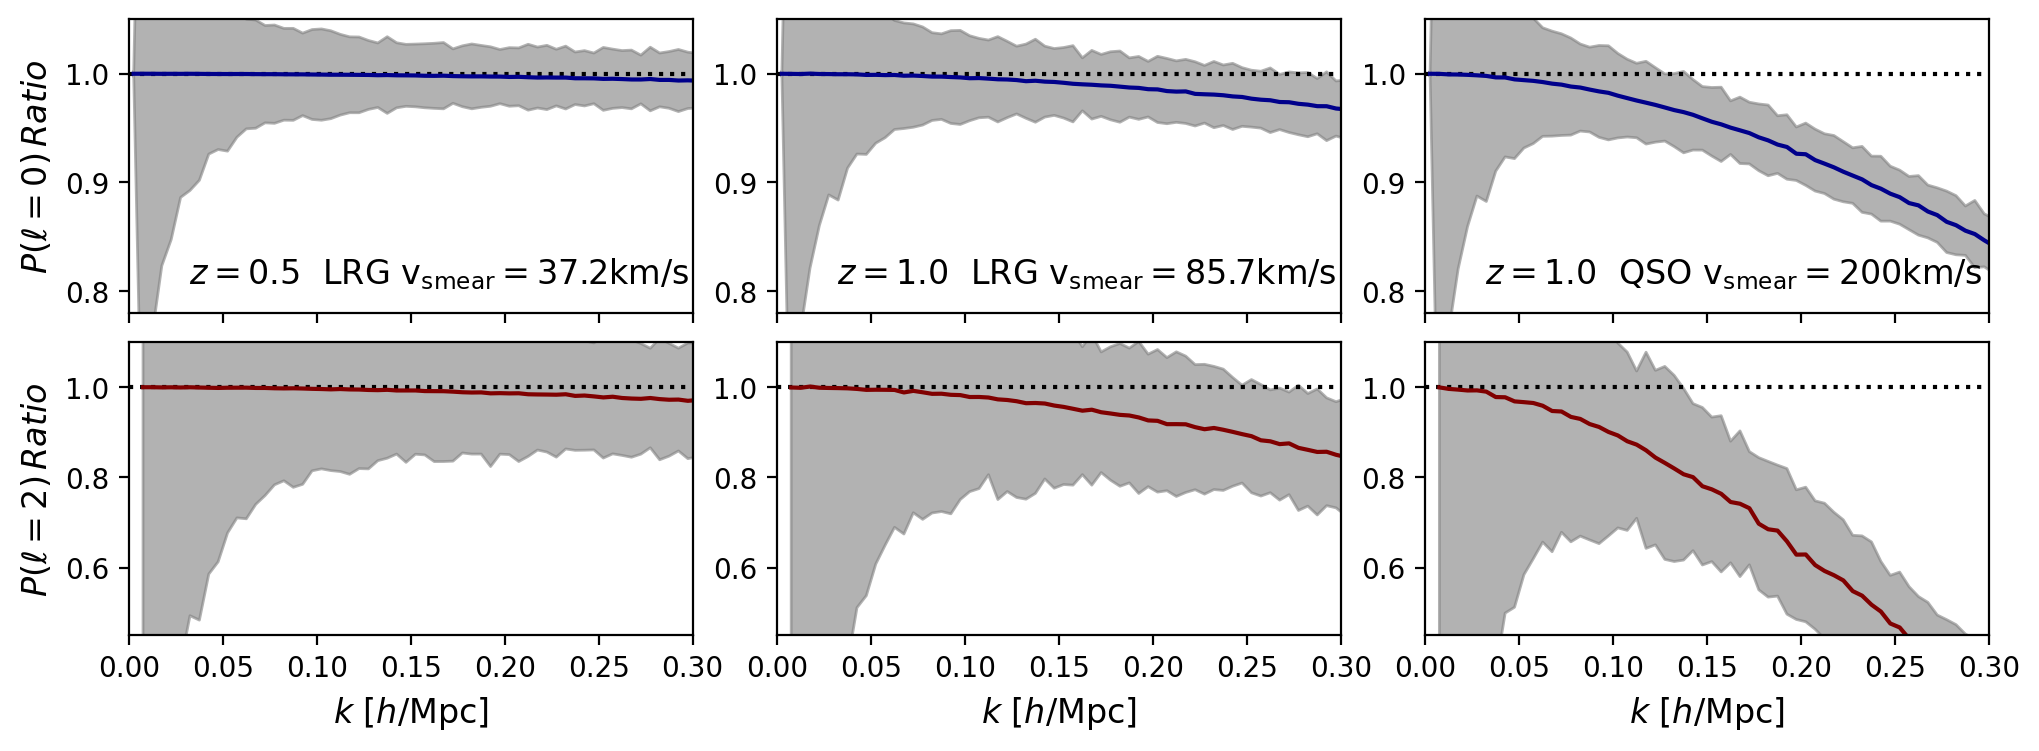

In [12]:
def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/fiducial/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

label_fontsize = 12
legend_fontsize = 12
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRG vsmear',
    'QSO': '+QSO vsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }
fig, axs = plt.subplots(2, 3, sharex=True, sharey=False, figsize = (12, 4))
fig.subplots_adjust(wspace=0.15)
fig.subplots_adjust(hspace=0.1)

colors = ['darkblue', 'maroon']
lss = ['-', '--']

for d in range(3):
    if d == 0:
        z_pk = 0.5
        r_pks = ['RSD', 'LRG']
    elif d == 1:
        z_pk = 1.0
        r_pks = ['RSD', 'LRG']   
    elif d == 2:
        z_pk = 1.0
        r_pks = ['RSD', 'QSO']  

    Pkobs = []
    labels = []
    for t,r_pk in enumerate(r_pks):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, z_pk)
        Pkobs.append([pk0, pk2])
        labels.append(f'obs {systematic}')
        if t == 0:
            rsf = 5
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]

    for ell, i in zip(['monopole','quadrupole'],range(2)):
        axs[i][d].axhline(1.0, color='k', linestyle=':', alpha=1.0)
        axs[i][d].plot(k_ev, (Pkobs[1][i][0]/Pkobs[0][i][0]), color = colors[i], linestyle=lss[t-1])
        axs[i][d].fill_between(k_ev,  (Pkobs[t][i][0]-Pkobs[t][i][1])/Pkobs[0][i][0],
                            (Pkobs[1][i][0]+Pkobs[1][i][1])/Pkobs[0][i][0],alpha=0.6, color='grey') 

        axs[1][d].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
        axs[i][0].set_ylabel(r'$P(\ell = {}) \, Ratio$'.format(i*2), fontsize = label_fontsize)
        axs[i][d].set_xlim([0.0,0.30])

        axs[0][d].set_ylim([0.78,1.05])
        axs[1][d].set_ylim([0.45,1.1])

plt.figtext(0.15, 0.55, r'$z=0.5 \ \ \rm{LRG} \  v_{smear} =  37.2 \rm{km/s}$', fontsize=legend_fontsize)
plt.figtext(0.42, 0.55, r'$z=1.0 \ \ \rm{LRG} \  v_{smear} =  85.7 \rm{km/s}$', fontsize=legend_fontsize)
plt.figtext(0.69, 0.55, r'$z=1.0 \ \ \rm{QSO} \ v_{smear} =  200 \rm{km/s}$', fontsize=legend_fontsize)
plt.show()

In [17]:
print(k_ev)

kmin     = 0.0025
kmax     = 0.3
binning  = 0.005
k_ev     = np.arange(kmin, kmax+0.001, binning)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}



[0.0025 0.0075 0.0125 0.0175 0.0225 0.0275 0.0325 0.0375 0.0425 0.0475
 0.0525 0.0575 0.0625 0.0675 0.0725 0.0775 0.0825 0.0875 0.0925 0.0975
 0.1025 0.1075 0.1125 0.1175 0.1225 0.1275 0.1325 0.1375 0.1425 0.1475
 0.1525 0.1575 0.1625 0.1675 0.1725 0.1775 0.1825 0.1875 0.1925 0.1975
 0.2025 0.2075 0.2125 0.2175 0.2225 0.2275 0.2325 0.2375 0.2425 0.2475
 0.2525 0.2575 0.2625 0.2675 0.2725 0.2775 0.2825 0.2875 0.2925 0.2975
 0.3025 0.3075 0.3125 0.3175 0.3225 0.3275 0.3325 0.3375 0.3425 0.3475
 0.3525 0.3575 0.3625 0.3675 0.3725 0.3775 0.3825 0.3875 0.3925 0.3975
 0.4025 0.4075 0.4125 0.4175 0.4225 0.4275 0.4325 0.4375 0.4425 0.4475
 0.4525 0.4575 0.4625 0.4675 0.4725 0.4775 0.4825 0.4875 0.4925]
[0.0025 0.0075 0.0125 0.0175 0.0225 0.0275 0.0325 0.0375 0.0425 0.0475
 0.0525 0.0575 0.0625 0.0675 0.0725 0.0775 0.0825 0.0875 0.0925 0.0975
 0.1025 0.1075 0.1125 0.1175 0.1225 0.1275 0.1325 0.1375 0.1425 0.1475
 0.1525 0.1575 0.1625 0.1675 0.1725 0.1775 0.1825 0.1875 0.1925 0.1975
 0.2025 0.20